# Review of classifiers using resampling based techniques.

The data I will use is in the `data/processed_dataset.joblib` which is a dictionary holding tuples of train and test set.
The data was preprocessed in the `0.2-data_prep.ipynb` notebook.

I'm going to go with (based off of the research found in `0.0-literature_research.md` file) these classifiers:
1. XGBoost
2. RandomForest
3. SVC
4. Logistic Regression with regularization

*NOTE*: SVC and Logistic Regression will be ran via a Stochastic Gradient Descent classifier due to the amount of data that it needs to sift through. Especially with the Random Search. It might be a good idea to see if those models, using their batch counterparts will perform better (without Random Search though).

With these sampling based methods (for fixing imbalance):
1. SMOTE+ENN
2. SMOTE+Tomek Links
3. ADASYN

And also Cost-sensitive learning based methods, for increasing the weight of misclassyfing the positive class.

I'm going to use those metrics to evaluate performance:
1. F1
2. Precision
3. Recall
4. Precision-Recall curve 
5. Average Precision score
    * Which is the AUC of the PR curve.

My first step will be to run a RandomSearchCV that will allow me to "quickly" find best hyperparameters. Then, I'm going to take 2-3 top models and see their learning curves to discover, if any tweaks regarding over- and underfitting may be done.
I'm also going to compare the average performance of those 3 sampling methods, by taking the top 3 models in each category and plotting it side by side.

*NOTE*: I'm gonna use imbalanced-learn pipeline as this is capable of properly applying the resampling methods on the test sets in CV.

### Summary:
* **The winner is Random Forest with SMOTETomek sampling** (based on the AUC of PR)

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
import numpy as np
import scipy

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from imblearn.pipeline import make_pipeline as imb_make_pipeline

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import ADASYN

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem

from sklearn.metrics import (
    precision_score, recall_score, precision_recall_curve, f1_score, 
    zero_one_loss, average_precision_score, auc
)
from sklearn.metrics import make_scorer

RANDOM_STATE = 42

In [2]:
data_dict = load("data/processed_dataset.joblib")
X_train = data_dict["training"][0].values
y_train = np.ravel(data_dict["training"][1])

In [3]:
from collections import namedtuple

# Instantiate the metrics we're gonna use in randomized search
scorers = ("precision", "recall", "f1", "roc_auc")

Classifier = namedtuple("Classifier", ["name", "model", "params"])
Sampler = namedtuple("Sampler", ["name", "model"])

# Instantiate classifiers in a list for iterating over it
classifiers = [
    # Both svc and log are based off of the SGD classifier.
    Classifier(
        name = "svc", 
        model = SGDClassifier(random_state=RANDOM_STATE, max_iter=1000, verbose=False),
        params = {
            "sgdclassifier__loss": ["hinge", "modified_huber", "squared_hinge"],
            "sgdclassifier__penalty": ["elasticnet", "l2", "l1"],
            "sgdclassifier__alpha": scipy.stats.expon(scale=0.01),
            "sgdclassifier__l1_ratio": scipy.stats.uniform(0, 0.5),
            # SVC will use Nystroem for kernel approx.
            "nystroem__kernel": ["rbf", "polynomial"],
            "nystroem__n_components": [100, 200, 400, 600],
            "nystroem__degree": [1,2,3,4,5]
        }
    ),
    Classifier(
        name = "log",
        model = SGDClassifier(loss="log", random_state=RANDOM_STATE, 
                              max_iter=1000, verbose=False),
        params = {
            "sgdclassifier__penalty": ["elasticnet", "l2", "l1"],
            "sgdclassifier__alpha": [0.0001, 0.0005, 0.001, 0.002],
            "sgdclassifier__l1_ratio": scipy.stats.uniform(0, 0.5)
        }
    ),
    Classifier(
        name = "rf",
        model = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE, verbose=False),
        params = {
            "randomforestclassifier__n_estimators": [10, 100, 400, 800],
            "randomforestclassifier__criterion": ["gini", "entropy"],
            "randomforestclassifier__min_samples_split": [2, 4, 8],
        }
    ),
    Classifier(
        name = "xgboost",
        model = XGBClassifier(n_jobs=-1, random_state=RANDOM_STATE, verbosity=0),
        params = {
            "xgbclassifier__max_depth": [3,6,8,12],
            "xgbclassifier__learning_rate": [0.1, 0.25, 0.5],
            "xgbclassifier__booster": ["gbtree", "gblinear", "dart"],
            "xgbclassifier__n_estimators": [100, 400, 800],
            "xgbclassifier__reg_alpha": [0, 0.1, 0.25, 0.5, 0.75, 1],
            "xgbclassifier__reg_lambda": [0, 0.1, 0.25, 0.5, 0.75, 1],
            "xgbclassifier__min_child_weight": [0.5,1,2,4,8,10]
        }
    )
]

sampling_methods = [
    Sampler(name="smoteenn", model=SMOTEENN(n_jobs=-1, random_state=RANDOM_STATE)),
    Sampler(name="smotetomek", model=SMOTETomek(n_jobs=-1, random_state=RANDOM_STATE)),
    Sampler(name="adasyn", model=ADASYN(n_jobs=-1, random_state=RANDOM_STATE))
]

feature_map_nystroem = Nystroem(random_state=RANDOM_STATE)

In [4]:
# random_search_results = {}
random_search_results = load("data/random_search_results.joblib")

# Sampling methods

## Training

In [5]:
# Iterate over all models and save output to a dict for later review and comparison
# We're going also to review the best models' (2-3) learning curves for finding any easy fixes.
for sampler in sampling_methods:
    print("+++++++++++++++++++++")
    print(f"Sampling with: {sampler.name}")
    
    # I've had to redo the iteration after smoteenn due to some bugs.
    # that's why I'm skipping it here.
    if sampler.name == "smoteenn":
        continue
    
    for clf in classifiers:
        
        imb_pipeline = imb_make_pipeline(
                sampler.model,
                clf.model, 
                memory="temp"
            )

        if any("nystroem__" in name for name in clf.params):
            print("Adding Nystroem kernel approximation...")
            imb_pipeline.steps.insert(1, ("nystroem", feature_map_nystroem))

        random_search = RandomizedSearchCV(
            imb_pipeline, 
            clf.params, 
            # Due to the amount of time it is required to compute
            # XGBoost, I'm halfing the n_iter.
            # Less comprehensive, but need to speed up stuff.
            n_iter=10, 
            refit="f1", 
            scoring=scorers,
            n_jobs=10,  
            iid=False, 
            cv=5, 
            verbose=False,
            random_state=RANDOM_STATE
        )

        print(f"Starting {clf.name}...")
        random_search.fit(X_train, y_train)

        random_search_results.setdefault(sampler.name, {})[clf.name] = random_search
        # Intermediate dumps, just for when something goes wrong and we don't
        # want to repeat the whole thing.
        dump(random_search_results, "data/random_search_results.joblib")

        print(f"Finished {clf.name}...")
        print("----------------")
    
dump(random_search_results, "data/random_search_results.joblib")

+++++++++++++++++++++
Sampling with: smoteenn
+++++++++++++++++++++
Sampling with: smotetomek
Adding Nystroem kernel approximation...
Starting svc...
Finished svc...
----------------
Starting log...
Finished log...
----------------
Starting rf...
Finished rf...
----------------
Starting xgboost...
Finished xgboost...
----------------
+++++++++++++++++++++
Sampling with: adasyn
Adding Nystroem kernel approximation...
Starting svc...
Finished svc...
----------------
Starting log...
Finished log...
----------------
Starting rf...
Finished rf...
----------------
Starting xgboost...
Finished xgboost...
----------------


['data/random_search_results.joblib']

## Evaluating the models
For simplicity's sake, I'm gonna take the top 3 models from each category (sampling method x model) and focus on the F1 score, which balances the Precision and Recall.

NOTE(s): 
* While testing the difference between SGDClassifier and normal SVC, I've found out that SVC significantly outperforms the SGDClassifier with kernel approximations. I've forfeited the normal SVC for RandomSearchCV  due to the time it required to train, but it'd be good to compare those two at later date. The reason for this difference might be the kernel approximation (maybe it needs more testing?)
* I also understand that SGDClassifier is much more sensitive to having properly scaled (mean 0 and std of 1) features. The only feature here that isn't scaled that way is `Time` which is scaled with a MinMaxScaler. Not sure if solely this can account for such a drastic difference in performance.


In [39]:
samplers_x_model_performance_list = []
for sampler in random_search_results.keys():
    for model in random_search_results[sampler].keys():
        
        temp_df = pd.DataFrame(random_search_results[sampler][model].cv_results_)[
            ["params",
             "mean_test_f1", 
             "std_test_f1", 
             "mean_test_precision", 
             "mean_test_recall", 
             "mean_test_roc_auc"]
        ] \
        .sort_values("mean_test_f1", ascending=False) \
        .head(3) \
        
        temp_df.insert(0, "sampler", sampler)
        temp_df.insert(1, "model", model)
        
        samplers_x_model_performance_list.append(temp_df)

top_performers_df = samplers_x_model_performance_list.pop(0)
top_performers_df = top_performers_df.append(samplers_x_model_performance_list)

In [40]:
top_performers_df

,sampler,model,params,mean_test_f1,std_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc
12,smoteenn,svc,"{'nystroem__degree': 4, 'nystroem__kernel': 'p...",0.279884,0.042804,0.167214,0.882912,0.958846
2,smoteenn,svc,"{'nystroem__degree': 5, 'nystroem__kernel': 'p...",0.250992,0.089855,0.150998,0.890947,0.955923
4,smoteenn,svc,"{'nystroem__degree': 2, 'nystroem__kernel': 'p...",0.188201,0.127690,0.112449,0.848351,0.928543
13,smoteenn,log,"{'sgdclassifier__alpha': 0.03370630342461173, ...",0.168904,0.010811,0.093296,0.898877,0.976681
19,smoteenn,log,"{'sgdclassifier__alpha': 0.03492807132736227, ...",0.153781,0.011486,0.084249,0.896246,0.975838
1,smoteenn,log,"{'sgdclassifier__alpha': 0.015127241738646855,...",0.139052,0.009479,0.075423,0.901579,0.973946
13,smoteenn,rf,"{'randomforestclassifier__n_estimators': 800, ...",0.844859,0.038171,0.859800,0.832491,0.981860
9,smoteenn,rf,"{'randomforestclassifier__n_estimators': 100, ...",0.843065,0.038986,0.859024,0.829825,0.970792
10,smoteenn,rf,"{'randomforestclassifier__n_estimators': 400, ...",0.842058,0.040173,0.857182,0.829825,0.982028
3,smoteenn,xgboost,"{'xgbclassifier__reg_lambda': 1, 'xgbclassifie...",0.791493,0.028085,0.748082,0.843123,0.975839


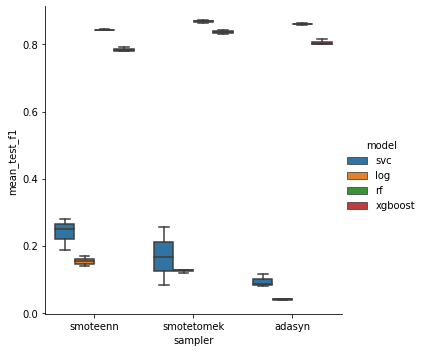

In [46]:
sns.catplot(x="sampler", y="mean_test_f1", hue="model", kind="box", data=top_performers_df)
plt.show()

We can see, that:
1. All samplers performed similarly, without a clear winner visible, but there are some differences depending on the models used.
2. `log` and `svc` models haven't worked out at all, that is they've performed significantly worse than other models.

Zooming in onto `rf` and `xgboost` models.

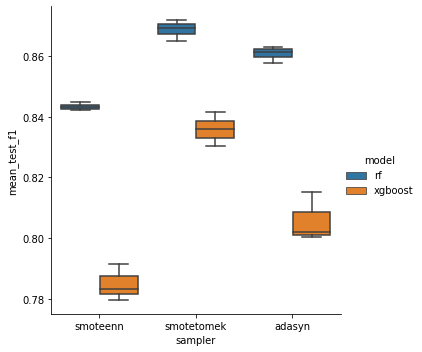

In [121]:
mask = ((top_performers_df["model"] == "rf") | (top_performers_df["model"] == "xgboost"))
sns.catplot(x="sampler", y="mean_test_f1", hue="model", kind="box", data=top_performers_df[mask])
plt.show()

Zooming in paints us an interesting picture of Random Forests performing **better** (on average) than Extreme Gradient Boost!     

From what internet knowledge tells us, XGBoost can outperform other methods but requires more tinkering with hyperparameters. An exhaustive GridSearchCV might be more suitable if we would try to squeeze the little performance improvement.  
**EDIT**: It looks like CSL based XGBoost outperformed CSL based RandomForests. This might also be the culprit (sampling vs cost-sensitive methods).

Additionally, above chart uses boxplots of the top three models, not including their respective standard deviation to calculate it's spread. Chart below does.

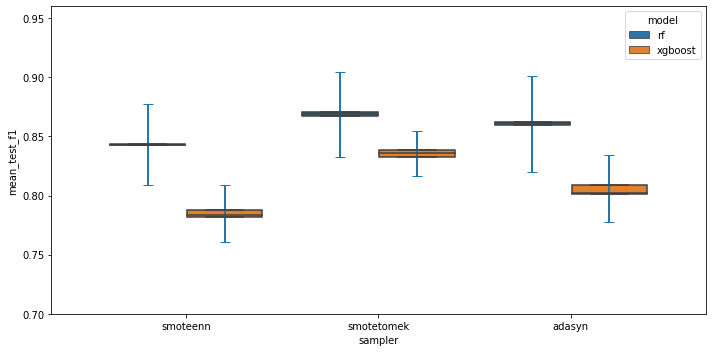

In [412]:
mask = ((top_performers_df["model"] == "rf") | (top_performers_df["model"] == "xgboost"))
aggregated_df = top_performers_df[mask].groupby(["sampler", "model"]).mean() \
    .reindex(
        pd.MultiIndex.from_product((["smoteenn", "smotetomek", "adasyn"], ["rf", "xgboost"]))
    )

# we're going to assume that the mean and std from the top 3 models
# comes from a Gaussian distribution.
means = aggregated_df["mean_test_f1"].values
sem = aggregated_df["std_test_f1"]/np.sqrt(5) # because 5 folds.
# Change this to a t-distribution based CI, which should be 2.78. 
# Not doing this here because time is of the essence and it isn't cirtical, 
# but the error bars in CSL methods do have the correct value passed.
errors = 1.96*sem 

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(
    x="sampler", y="mean_test_f1", hue="model", data=top_performers_df[mask], whis=0, fliersize=0
)
ax.set_ylim(bottom=0.7, top=0.96)
plt.errorbar([-0.2,.2,.8, 1.2, 1.8, 2.2], means, errors, elinewidth=2, capsize=5, fmt="none")
plt.tight_layout()

We can see here that most of the samples overlap each other within their respective error ranges, meaning, that we can't be sure if anything outdoes other models. 

The only interesting part here is that based on our samples, smoteenn xgboost performed worse than smotetomek's random forest.
It also looks like on average (but still within error) SMOTE with Tomek links cleaning performed better than other models and the close second is ADASYN.

Based on the data I'd say the winner for now is Random Forest + SMOTETomek (for sampling based methods).

### Learning Curves
Based on the winning models (RF and XGBoost w/ SMOTETomek sampling) I'm going to plot learning curves to uncover more information.

In [459]:
# I stole this from the scikit learn's page
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from scripts.helper_funcs import plot_learning_curve

#### Random Forest

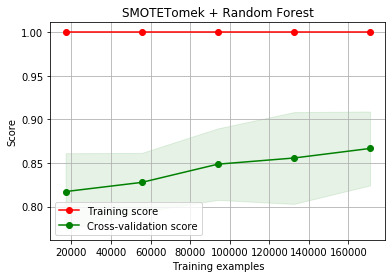

In [472]:
# F1
estimator = random_search_results["smotetomek"]["rf"].best_estimator_
train_sizes, train_scores, test_scores = plot_learning_curve(
    estimator, "SMOTETomek + Random Forest", X_train, y_train, cv=5, n_jobs=-1, scorer="f1"
)
plt.show()

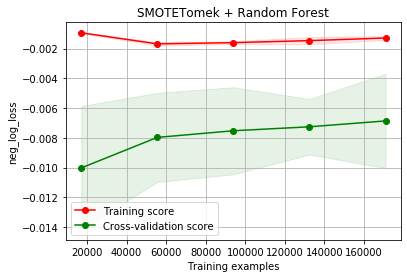

In [484]:
# Log Loss
estimator = random_search_results["smotetomek"]["rf"].best_estimator_
train_sizes, train_scores, test_scores = plot_learning_curve(
    estimator, "SMOTETomek + Random Forest", X_train, y_train, cv=5, n_jobs=-1, scorer="neg_log_loss"
)
plt.show()

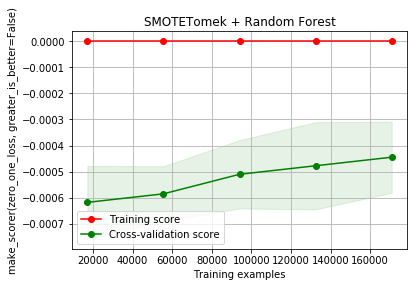

In [506]:
# zero_one_loss. Added after log_loss wasn't achievable in XGBoost.
estimator = random_search_results["smotetomek"]["rf"].best_estimator_
train_sizes, train_scores, test_scores = plot_learning_curve(
    estimator, "SMOTETomek + Random Forest", X_train, y_train, cv=5, n_jobs=-1, 
    scorer=make_scorer(zero_one_loss, greater_is_better=False)
)
plt.show()

Summary: Looks like it still could gain some benefit from a larger sample size, as depicted by the F1 and loss curves. In both plots the trend is positive.

#### XGBoost

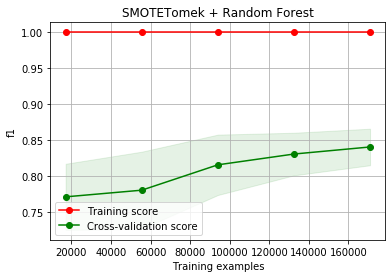

In [485]:
# F1
estimator = random_search_results["smotetomek"]["xgboost"].best_estimator_
train_sizes, train_scores, test_scores = plot_learning_curve(
    estimator, "SMOTETomek + XGBoost", X_train, y_train, cv=5, n_jobs=-1, scorer="f1"
)
plt.show()

**NOTE:** I made a slight mistake with naming this plot - it should be named XGBoost instead of Random Forest. Not re-running it due to the time it takes to get results.

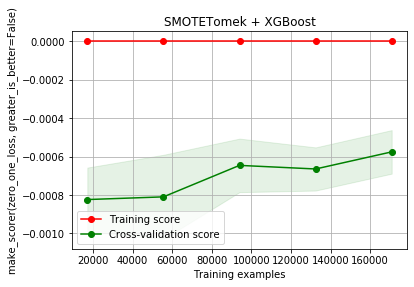

In [502]:
# Log Loss isn't available as this returns too many values that invalid for it to compute (zero's and maybe NaN's?)
# going for zero_one_loss
estimator = random_search_results["smotetomek"]["xgboost"].best_estimator_
train_sizes, train_scores, test_scores = plot_learning_curve(
    estimator, "SMOTETomek + XGBoost", X_train[:-1], y_train[:-1], cv=5, n_jobs=-1, 
    scorer=make_scorer(zero_one_loss, greater_is_better=False)
)
plt.show()

Looking at those two charts above we can say that it, like with Random Forests, the trend is positive for the cross-validation score. Meaning, that if maybe we had more data the model's prediction would be better.

#### Precision/Recall comparison

In [528]:
mask = ((top_performers_df["sampler"] == "smotetomek") & ((top_performers_df["model"] == "rf") | (top_performers_df["model"] == "xgboost")))
top_performers_df[mask][["sampler", "model", "mean_test_f1", "mean_test_precision", "mean_test_recall"]].set_index(["sampler", "model"])

mean_test_f1  mean_test_precision  mean_test_recall
sampler    model                                                       
smotetomek rf           0.871733             0.920992          0.829860
           rf           0.869219             0.915280          0.829860
           rf           0.865082             0.909377          0.827193
           xgboost      0.841549             0.864063          0.824491
           xgboost      0.835806             0.849049          0.829860
           xgboost      0.830238             0.830549          0.835123

Looks like the recall scores are very comparable between the top 3 Random Forest models and top 3 XGBoost models. The only difference is in the precision score.
Honestly, a more important metric for us is recall, as we're interested more in avoiding False Negatives. But due to it being comparable, we'll go with RF models as the increase in Precision is much better.

**EDIT**: It would be a good idea to run Precision-Recall curves (or just take AUC from them) to select the best model out of the bunch, but due to time constraints, I'm gonna leave this evaluation for the last competing models. For now, I'm just gonna take the model with highest F1 score, which is not ideal, but it's "good enough" for now.

## Summary
Overall, looks like the SMOTETomek + RandomForest had a better head start and (on current dataset) has better scores. But the difference isn't too big.
I'm really intrigued by the the fact that RandomForest outperformed XGBoost. But from what I could gather this may be attributed to hyperpamater tuning, as well tuned XGBoost algorithm typically outperforms other models.

The only thing left (beside doing the cost-sensitive learning part) is validating the model score on the held out test data, while being fitted to the training data.

# Cost-sensitive learning methods

In this section I'm going to abandon the sampling methods for imbalanced datasets and focus on cost-sensitive learning approach, where the models will be focused on assigning more weight to misclassified minority class.

In [3]:
from collections import namedtuple

# Instantiate the metrics we're gonna use in randomized search
scorers = ("precision", "recall", "f1")

Classifier = namedtuple("Classifier", ["name", "model", "params"])
# Instantiate classifiers in a list for iterating over it
classifiers = [
    # Both svc and log are based off of the SGD classifier.
    Classifier(
        name = "svc", 
        model = SGDClassifier(random_state=RANDOM_STATE, max_iter=1000, verbose=False,
                              class_weight="balanced"),
        params = {
            "sgdclassifier__loss": ["hinge", "modified_huber", "squared_hinge"],
            "sgdclassifier__penalty": ["elasticnet", "l2", "l1"],
            "sgdclassifier__alpha": scipy.stats.expon(scale=0.01),
            "sgdclassifier__l1_ratio": scipy.stats.uniform(0, 0.5),
            # SVC will use Nystroem for kernel approx.
            "nystroem__kernel": ["rbf", "polynomial"],
            "nystroem__n_components": [100, 200, 400, 600],
            "nystroem__degree": [1,2,3,4,5]
        }
    ),
    Classifier(
        name = "log",
        model = SGDClassifier(loss="log", random_state=RANDOM_STATE, 
                              max_iter=1000, verbose=False, class_weight="balanced"),
        params = {
            "sgdclassifier__penalty": ["elasticnet", "l2", "l1"],
            "sgdclassifier__alpha": [0.0001, 0.0005, 0.001, 0.002],
            "sgdclassifier__l1_ratio": scipy.stats.uniform(0, 0.5)
        }
    ),
    Classifier(
        name = "rf",
        model = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE, verbose=False,
                                       class_weight="balanced_subsample"),
        params = {
            "randomforestclassifier__n_estimators": [10, 100, 400, 800],
            "randomforestclassifier__criterion": ["gini", "entropy"],
            "randomforestclassifier__min_samples_split": [2, 4, 8],
            # Not sure which one will prove better
            "randomforestclassifier__class_weight": ["balanced_subsample", "balanced"]
        }
    ),
    Classifier(
        name = "xgboost",
        model = XGBClassifier(n_jobs=-1, random_state=RANDOM_STATE, verbosity=0,
                              scale_pos_weight=578), # sum(neg) / sum(pos)
        params = {
            "xgbclassifier__max_depth": [3,6,8,12],
            "xgbclassifier__learning_rate": [0.1, 0.25, 0.5],
            "xgbclassifier__booster": ["gbtree", "gblinear", "dart"],
            "xgbclassifier__n_estimators": [100, 400, 800],
            "xgbclassifier__reg_alpha": [0, 0.1, 0.25, 0.5, 0.75, 1],
            "xgbclassifier__reg_lambda": [0, 0.1, 0.25, 0.5, 0.75, 1],
            "xgbclassifier__min_child_weight": [0.5,1,2,4,8,10]
        }
    )
]

feature_map_nystroem = Nystroem(random_state=RANDOM_STATE)

In [4]:
# csl_random_search_results = {}
csl_random_search_results = load("data/csl_random_search_results.joblib")

In [6]:
# Iterate over all models and save output to a dict for later review and comparison
# We're going also to review the best models' (2-3) learning curves for finding any easy fixes.
for clf in classifiers:

    imb_pipeline = imb_make_pipeline(
            clf.model, 
            memory="temp"
        )

    if any("nystroem__" in name for name in clf.params):
        print("Adding Nystroem kernel approximation...")
        imb_pipeline.steps.insert(0, ("nystroem", feature_map_nystroem))

    random_search = RandomizedSearchCV(
        imb_pipeline, 
        clf.params,
        n_iter=10, 
        refit="f1", 
        scoring=scorers,
        n_jobs=10,  
        iid=False, 
        cv=5, 
        verbose=False,
        random_state=RANDOM_STATE
    )

    print(f"Starting {clf.name}...")
    random_search.fit(X_train, y_train)

    csl_random_search_results[clf.name] = random_search
    # Intermediate dumps, just for when something goes wrong and we don't
    # want to repeat the whole thing.
    dump(csl_random_search_results, "data/csl_random_search_results.joblib")

    print(f"Finished {clf.name}...")
    print("----------------")
    
dump(csl_random_search_results, "data/csl_random_search_results.joblib")

Adding Nystroem kernel approximation...
Starting svc...
Finished svc...
----------------
Starting log...
Finished log...
----------------
Starting rf...
Finished rf...
----------------
Starting xgboost...
Finished xgboost...
----------------


['data/csl_random_search_results.joblib']

That was DEFINITELY much quicker.

In [10]:
csl_model_performance_list = []
for model in csl_random_search_results.keys():

    temp_df = pd.DataFrame(csl_random_search_results[model].cv_results_)[
        ["params",
         "mean_test_f1", 
         "std_test_f1", 
         "mean_test_precision", 
         "mean_test_recall"]
    ] \
    .sort_values("mean_test_f1", ascending=False) \
    .head(3) \

    temp_df.insert(0, "model", model)

    csl_model_performance_list.append(temp_df)

csl_top_performers_df = csl_model_performance_list.pop(0)
csl_top_performers_df = csl_top_performers_df.append(csl_model_performance_list)

In [11]:
csl_top_performers_df

,model,params,mean_test_f1,std_test_f1,mean_test_precision,mean_test_recall
6,svc,"{'nystroem__degree': 5, 'nystroem__kernel': 'r...",0.067025,0.007288,0.034813,0.920105
8,svc,"{'nystroem__degree': 4, 'nystroem__kernel': 'r...",0.065053,0.013718,0.033803,0.920105
9,svc,"{'nystroem__degree': 2, 'nystroem__kernel': 'p...",0.059433,0.027251,0.030996,0.885754
1,log,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.112080,0.023032,0.059913,0.912246
9,log,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.111573,0.033315,0.059708,0.906912
5,log,"{'sgdclassifier__alpha': 0.0005, 'sgdclassifie...",0.096607,0.016969,0.051185,0.901614
3,rf,"{'randomforestclassifier__n_estimators': 800, ...",0.850926,0.048766,0.956510,0.768772
1,rf,"{'randomforestclassifier__n_estimators': 10, '...",0.849402,0.037301,0.950626,0.768737
7,rf,"{'randomforestclassifier__n_estimators': 800, ...",0.849070,0.051025,0.956251,0.766105
1,xgboost,"{'xgbclassifier__reg_lambda': 0.25, 'xgbclassi...",0.868989,0.032873,0.928524,0.819193


We can already clearly see that we're dealing with similar performance as in the sampling based methods. We're going to focus on RF and XGBoost from now on, as Stochastic Gradient Descent methods proved to be highly ineffective, as shown by the F1 score.

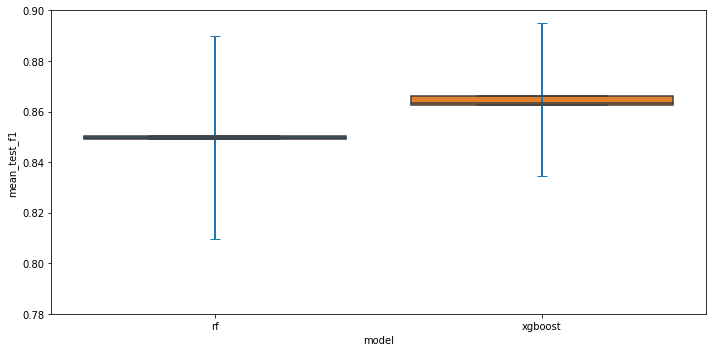

In [19]:
mask = ((csl_top_performers_df["model"] == "rf") | (csl_top_performers_df["model"] == "xgboost"))
aggregated_df = csl_top_performers_df[mask].groupby("model").mean()

# we're going to assume that the mean and std from the top 3 models
# comes from a Gaussian distribution.
means = aggregated_df["mean_test_f1"].values
sem = aggregated_df["std_test_f1"]/np.sqrt(5) # because 5 folds.
errors = 2.78*sem

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(
    x="model", y="mean_test_f1", data=csl_top_performers_df[mask], whis=0, fliersize=0
)

# we're going to assume that the mean and std from the top 3 models
# comes from a Gaussian distribution.
means = aggregated_df["mean_test_f1"].values
sem = aggregated_df["std_test_f1"]/np.sqrt(5) # because 5 folds.
errors = 1.96*sem # < change this to a t-distribution based CI

ax.set_ylim(bottom=0.78, top=0.90)
plt.errorbar([0, 1], means, errors, elinewidth=2, capsize=5, fmt="none")
plt.tight_layout()

No difference between those models it looks like.

## Learning Curves
I've modified the script a bit to display both loss and score learning curves side by side.

In [33]:
from scripts.helper_funcs import plot_learning_curves

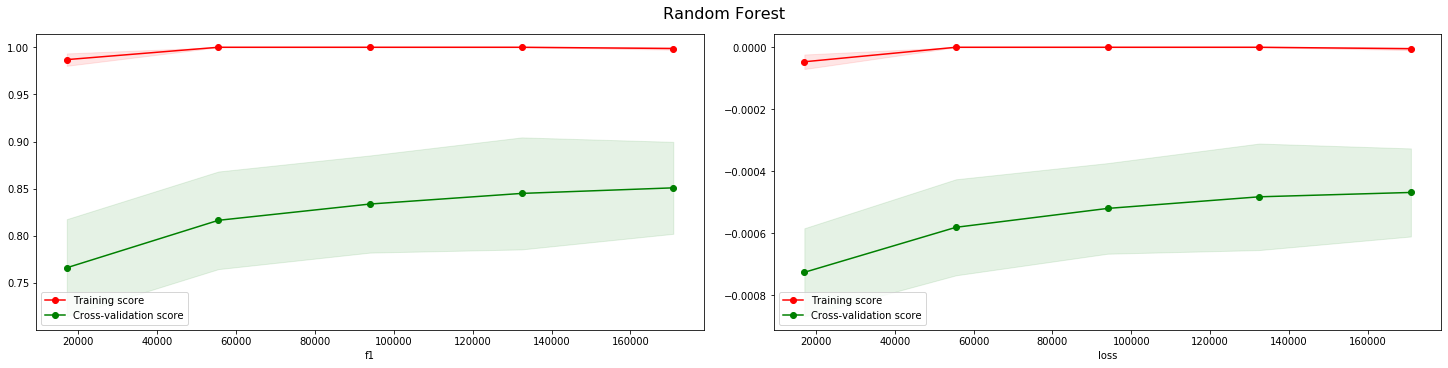

In [42]:
estimator = csl_random_search_results["rf"].best_estimator_
plot_learning_curves(estimator, "Random Forest", X_train, y_train)

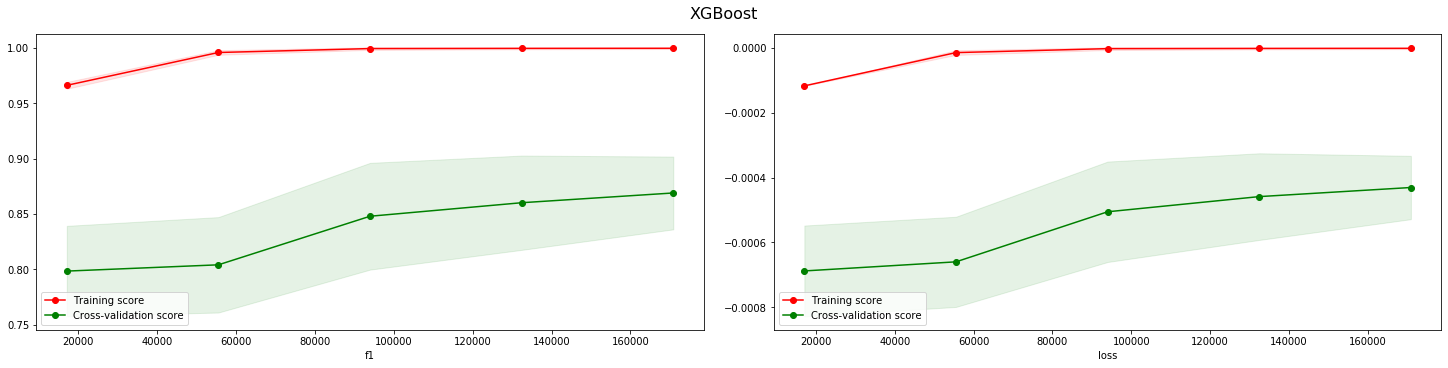

In [43]:
estimator = csl_random_search_results["xgboost"].best_estimator_
plot_learning_curves(estimator, "XGBoost", X_train, y_train)

It looks like, just like with the models which also used sampling, that the trend is also positive, albeit it plateus harder. 
Also, Random Forest generally has a higher standard deviation in-between the validation scores.

### Precision/Recall comparison

In [45]:
mask = ((csl_top_performers_df["model"] == "rf") | (csl_top_performers_df["model"] == "xgboost"))
csl_top_performers_df[mask][["model", "mean_test_f1", "mean_test_precision", "mean_test_recall"]].set_index("model")

,mean_test_f1,mean_test_precision,mean_test_recall
model,,,
rf,0.850926,0.956510,0.768772
rf,0.849402,0.950626,0.768737
rf,0.849070,0.956251,0.766105
xgboost,0.868989,0.928524,0.819193
xgboost,0.863521,0.922448,0.813860
xgboost,0.861422,0.904033,0.824491


Interesting to note, that while the Recall score in-between model difference in models that utilized sampling methods was none, here it is much more pronounced.   

XGBoost is better at handling False Negatives than Random Forest with CSL based tehcniques. The only thing it's slightly worse is with Precision, which isn't as important.  
The scores of the best XGBoost method is very close to that of the best RF with SMOTE+Tomek.

### Summary

In the case of cost-sensitive learning based handling of imbalanced datasets, the winner is XGBoost.  
I will compare SMOTE+Tomek Random Forests with CSL XGBoost on the test datasets.

# Final model evaluation
Based on the two winners (Random Forest w/ SMOTE+Tomek and XGBoost with scale_pos_weight set) that were determined by Randomized Search and Cross-Validation, we're going to see how they perform on the test set to evaluate their performance and choose the best model.

We're gonna use:
* F1 Score
* Precision-Recall Curve
* Average precision score

And we're also going to take into the account the learning times.

In [48]:
X_train = data_dict["training"][0].values
y_train = np.ravel(data_dict["training"][1])

X_test = data_dict["test"][0].values
y_test = np.ravel(data_dict["test"][1])

In [47]:
# Get the best model
sampling_random_search_results = load("data/random_search_results.joblib")
csl_random_search_results = load("data/csl_random_search_results.joblib")

best_sampling_rf = sampling_random_search_results["smotetomek"]["rf"].best_estimator_
best_csl_xgboost = csl_random_search_results["xgboost"].best_estimator_

In [64]:
from timeit import default_timer as timer

rf_start = timer()
best_sampling_rf.fit(X_train, y_train)
rf_end = timer()
print(f"Training of Random Forest with SMOTETomek sampling took: {(rf_end - rf_start):.2f} seconds")

xgboost_start = timer()
best_csl_xgboost.fit(X_train, y_train)
xgboost_end = timer()
print(f"Training of XGBoost with Cost-sensitive learning took: {(xgboost_end - xgboost_start):.2f} seconds")

Training of Random Forest with SMOTETomek sampling took: 43.75 seconds
Training of XGBoost with Cost-sensitive learning took: 54.96 seconds


Both classifiers are quite quick to fit on my machine. But please note that in both cases I had for fitting and transforming data.  
This means, that although XGBoost was slightly longer, on a new machine the Random Forest with SMOTETomek sampling will take longer, due to the additional step of calculating the SMOTE and Tomek links cleaning.

In [133]:
best_sampling_rf_y_predict = best_sampling_rf.predict(X_test)
best_sampling_rf_y_prob = best_sampling_rf.predict_proba(X_test)

best_csl_xgboost_y_predict = best_csl_xgboost.predict(X_test)
best_csl_xgboost_y_prob = best_csl_xgboost.predict_proba(X_test)

In [153]:
names = ["Random Forest with SMOTETomek sampling", "XGBoost with Cost-sensitive learning"]
predictions = [best_sampling_rf_y_predict, best_csl_xgboost_y_predict]
proba = [best_sampling_rf_y_prob, best_csl_xgboost_y_prob]
for model_name, y_pred, y_prob in zip(names, predictions, proba):
    print(f"For {model_name}:")
    print(f"--> F1 score: {f1_score(y_test, y_pred):.3f}")
    print(f"--> Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"--> Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"--> Average precision score: {average_precision_score(y_test, y_prob[:,1]):.3f}")
    print()

For Random Forest with SMOTETomek sampling:
--> F1 score: 0.828
--> Precision: 0.847
--> Recall: 0.810
--> Average precision score: 0.870

For XGBoost with Cost-sensitive learning:
--> F1 score: 0.843
--> Precision: 0.879
--> Recall: 0.810
--> Average precision score: 0.860



Based on the final test set, it looks like both models are valid, with XGBoost having a higher F1 and Precision scores (but same Recall score, which was more important than Precision), but slightly less Average Precision, which summarizes the Precision-Recall curve.

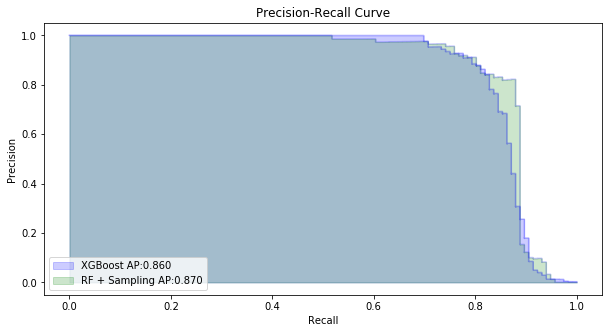

In [178]:
fig, ax = plt.subplots(figsize=(10,5))

# XGBoost
precision, recall, thresh = precision_recall_curve(y_test, best_csl_xgboost_y_prob[:, 1])


ax.step(recall, precision, color='b', alpha=0.2,
         where='post')
ax.fill_between(recall, precision, alpha=0.2, color='b', step='post', 
                label=f"XGBoost AP:{average_precision_score(y_test, best_csl_xgboost_y_prob[:,1]):.3f}")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

#RF
precision, recall, thresh = precision_recall_curve(y_test, best_sampling_rf_y_prob[:, 1])

# plot the precision_recall_curve side by side
ax.step(recall, precision, color='b', alpha=0.2,
         where='post')
ax.fill_between(recall, precision, alpha=0.2, color='g', step='post',
                label=f"RF + Sampling AP:{average_precision_score(y_test, best_sampling_rf_y_prob[:,1]):.3f}")

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Summary

The difference between those two models (Random Forest with SMOTE+Tomek sampling and Cost-sensitive Learning based XGBoost) is really small.
On one hand, the Average Precision score (which summarizes the PR curve) is better with Random Forest + SMOTETomek classifier, but it might be a bit slower than XGBoost due to the additional SMOTE+Tomek links step.

Also, the F1 score was a bit higher with XGBoost, but this was mainly due to Precision increase, as both models had a Recall of 0.81 on the test dataset.

**The winner is Random Forest with SMOTETomek sampling** (based on the AUC of PR curve)

In [154]:
best_sampling_rf

Pipeline(memory='temp',
         steps=[('smotetomek',
                 SMOTETomek(n_jobs=-1, random_state=42, ratio=None,
                            sampling_strategy='auto', smote=None, tomek=None)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='entropy', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=8,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=False, random_state=42,
                                        verbose=False,